# Lab Streaming Layer (LSL) Example
## This toolbox implemnts the lsl ecosystem which can be utilized for offline use cases as well as live streamings
In this example the data introduced in the first demo is being analyzed in a similar manner, This time however integrating a lsl stream.  

In [1]:
from mne_lsl import stream_viewer
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from py_neuromodulation import (nm_stream_abc, nm_plots, nm_IO, nm_define_nmchannels, nm_analysis, nm_stream_offline, nm_settings, nm_generator)
import mne
import threading
import time 
import random
%matplotlib inline

Let's get some data and create the nm_channels DataFrame

In [2]:
(
    RUN_NAME,
    PATH_RUN,
    PATH_BIDS,
    PATH_OUT,
    datatype,
) = nm_IO.get_paths_example_data()

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference="default",
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog", "dbs", "seeg"),
    target_keywords=["MOV_RIGHT"],
)

nm_channels
print(nm_IO.get_paths_example_data())



Extracting parameters from /Users/Sam/charite/py_neuro/py_neuromodulation/py_neuromodulation/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-gripforce_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /Users/Sam/charite/py_neuro/py_neuromodulation/py_neuromodulation/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-gripforce_run-0_channels.tsv.
Reading electrode coords from /Users/Sam/charite/py_neuro/py_neuromodulation/py_neuromodulation/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_space-mni_electrodes.tsv.
('sub-testsub_ses-EphysMedOff_task-gripforce_run-0', PurePosixPath('/Users/Sam/charite/py_neuro/py_neuromodulation/py_neuromodulation/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-gripforce_run-0'), PurePosixPath('/Users/Sam/charite/py_neuro/py_neuromodulation/py_neuromodulation/data'), PurePosixPath('/Users/Sam/charite/py_neuro/py_neuromodulation/py_neuromodulatio

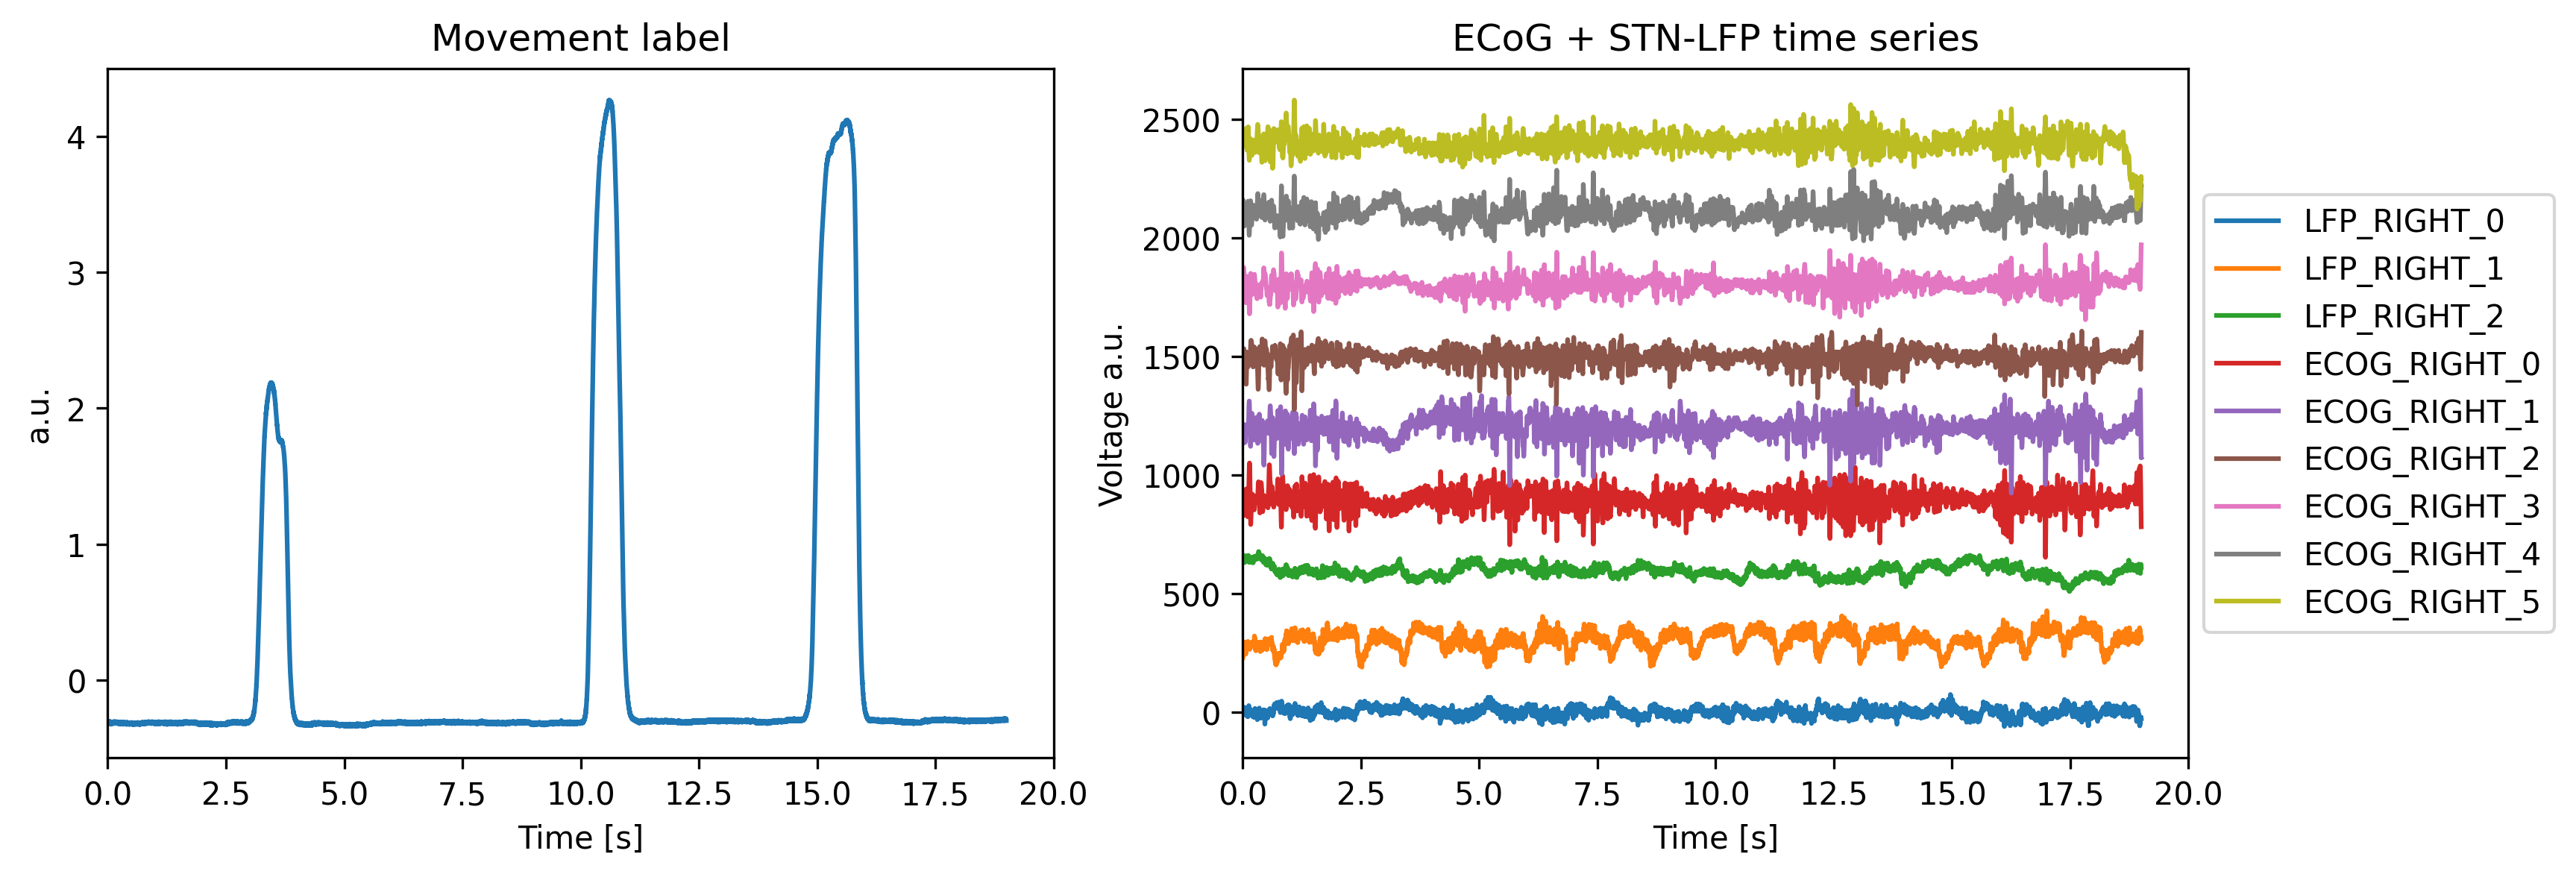

In [3]:
plt.figure(figsize=(12, 4), dpi=300)
plt.subplot(121)
plt.plot(raw.times, data[-1, :])
plt.xlabel("Time [s]")
plt.ylabel("a.u.")
plt.title("Movement label")
plt.xlim(0, 20)

plt.subplot(122)
for idx, ch_name in enumerate(nm_channels.query("used == 1").name):
    plt.plot(raw.times, data[idx, :] + idx * 300, label=ch_name)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.title("ECoG + STN-LFP time series")
plt.xlabel("Time [s]")
plt.ylabel("Voltage a.u.")
plt.xlim(0, 20)
plt.show()

### Playing the Data
Now we need our Data to be produced in some way.\
For this example a LSL Player is utilized which is playing our earlier recorderd data. However, you could make use of any LSL source (live or offline).\
If you want to bind your own data source, make sure to specify the necessariy parameters (data type, type, name) accordingly.\
If you are unsure about the parameters of your data source you can always search for available lsl streams.


In [4]:
settings = nm_settings.get_default_settings()
settings = nm_settings.set_settings_fast_compute(settings)

player = nm_generator.LSLOfflinePlayer(data= data, sfreq = 1000, settings = settings, stream_name="example_stream")

Creating RawArray with float64 data, n_channels=10, n_times=19001
    Range : 0 ... 19000 =      0.000 ...    19.000 secs
Ready.
Overwriting existing file.
Writing /Users/Sam/charite/py_neuro/py_neuromodulation/examples/temp_raw.fif
Closing /Users/Sam/charite/py_neuro/py_neuromodulation/examples/temp_raw.fif
[done]
Opening raw data file /Users/Sam/charite/py_neuro/py_neuromodulation/examples/temp_raw.fif...
Isotrak not found
    Range : 0 ... 19000 =      0.000 ...    19.000 secs
Ready.
Reading 0 ... 19000  =      0.000 ...    19.000 secs...


2024-05-07 12:05:07.923 (   3.475s) [          E82C67]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 32768, multicast: 1, broadcast: 0)
2024-05-07 12:05:07.923 (   3.475s) [          E82C67]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 32768, multicast: 1, broadcast: 0)
2024-05-07 12:05:07.923 (   3.475s) [          E82C67]      netinterfaces.cpp:102   INFO| 	IPv4 addr: 7f000001
2024-05-07 12:05:07.923 (   3.475s) [          E82C67]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 32768, multicast: 1, broadcast: 0)
2024-05-07 12:05:07.923 (   3.475s) [          E82C67]      netinterfaces.cpp:105   INFO| 	IPv6 addr: ::1
2024-05-07 12:05:07.923 (   3.476s) [          E82C67]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 32768, multicast: 1, broadcast: 0)
2024-05-07 12:05:07.923 (   3.476s) [          E82C67]      netinterfaces.cpp:105   INFO| 	IPv6 addr: fe80::1%lo0
2024-05-07 12:05:07.923 (   3.476s) [          E82C67]      netinterfaces.cpp:91    I

### Creating the LSLSTream Object
Next let's create a Stream analog to the First Demo's example
However as we run the stream, we will set the *lsl-stream* value to True and pass the stream name we earlier declared when initializing the player object 

In [5]:
settings = nm_settings.get_default_settings()
settings = nm_settings.set_settings_fast_compute(settings)

settings["features"]["welch"] = True
settings["features"]["fft"] = True
settings["features"]["bursts"] = True
settings["features"]["sharpwave_analysis"] = True
settings["features"]["coherence"] = True
settings["coherence"]["channels"] = [["LFP_RIGHT_0", "ECOG_RIGHT_0"]]
settings["coherence"]["frequency_bands"] = ["high beta", "low gamma"]
settings["sharpwave_analysis_settings"]["estimator"]["mean"] = []
for sw_feature in list(
    settings["sharpwave_analysis_settings"]["sharpwave_features"].keys()
):
    settings["sharpwave_analysis_settings"]["sharpwave_features"][
        sw_feature
    ] = True
    settings["sharpwave_analysis_settings"]["estimator"]["mean"].append(
        sw_feature
    )

In [6]:
stream = nm_stream_offline.Stream(
    sfreq=sfreq, nm_channels=nm_channels, settings=settings, coord_list=coord_list,verbose=True, line_noise=line_noise,
)

In [7]:
features = stream.run(stream_lsl= True, stream_lsl_name="example_stream")

py_neuromodulation:	Last batch took: 0.03 seconds
py_neuromodulation:	1.00 seconds of data processed
This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.
py_neuromodulation:	Last batch took: 0.04 seconds
py_neuromodulation:	1.10 seconds of data processed
py_neuromodulation:	Last batch took: 0.03 seconds
py_neuromodulation:	1.20 seconds of data processed
py_neuromodulation:	Last batch took: 0.03 seconds
py_neuromodulation:	1.30 seconds of data processed
py_neuromodulation:	Last batch took: 0.03 seconds
py_neuromodulation:	1.40 seconds of data processed
py_neuromodulation:	Last batch took: 0.03 seconds
py_neuromodulation:	1.50 seconds of data processed
py_neuromodulation:	Last batch took: 0.03 seconds
py_neuromodulation:	1.60 seconds of data processed
py_neuromodulation:	Last batch took: 0.03 seconds
py_neuromodulation:	1.70 seconds of data processed
py_neuromodulation:	Last batch took: 0.03 seconds
py_neuromodulation:	1.80 

In [8]:
features.head()

,LFP_RIGHT_0-LFP_RIGHT_2_fft_theta_mean,LFP_RIGHT_0-LFP_RIGHT_2_fft_alpha_mean,LFP_RIGHT_0-LFP_RIGHT_2_fft_low beta_mean,LFP_RIGHT_0-LFP_RIGHT_2_fft_high beta_mean,LFP_RIGHT_0-LFP_RIGHT_2_fft_low gamma_mean,LFP_RIGHT_0-LFP_RIGHT_2_fft_high gamma_mean,LFP_RIGHT_0-LFP_RIGHT_2_fft_HFA_mean,LFP_RIGHT_1-LFP_RIGHT_0_fft_theta_mean,LFP_RIGHT_1-LFP_RIGHT_0_fft_alpha_mean,LFP_RIGHT_1-LFP_RIGHT_0_fft_low beta_mean,...,coh_LFP_RIGHT_0_to_ECOG_RIGHT_0_mean_fband_low gamma,coh_LFP_RIGHT_0_to_ECOG_RIGHT_0_max_fband_low gamma,coh_LFP_RIGHT_0_to_ECOG_RIGHT_0_max_allfbands_low gamma,icoh_LFP_RIGHT_0_to_ECOG_RIGHT_0_mean_fband_high beta,icoh_LFP_RIGHT_0_to_ECOG_RIGHT_0_max_fband_high beta,icoh_LFP_RIGHT_0_to_ECOG_RIGHT_0_mean_fband_low gamma,icoh_LFP_RIGHT_0_to_ECOG_RIGHT_0_max_fband_low gamma,icoh_LFP_RIGHT_0_to_ECOG_RIGHT_0_max_allfbands_low gamma,time,MOV_RIGHT
0,3.358601,3.251910,3.152779,2.889127,2.374604,2.243889,1.957246,3.549376,3.310721,3.344487,...,0.175987,0.317353,234.375000,0.010372,0.030596,-0.513597,-0.021440,484.375000,1000.0,-0.306761
1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,...,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1100.0,-0.314528
2,0.942318,-1.395301,0.702041,0.940432,0.442519,0.867935,-1.414110,1.319862,0.274314,-0.905520,...,-1.346998,-1.410346,0.707107,-1.411928,-1.409961,-0.057296,0.747198,-1.372813,1200.0,-0.320790
3,0.700315,1.052752,1.080853,0.752346,-1.486165,-1.568579,-1.590734,-0.990737,-1.640015,0.851838,...,-0.498039,-0.436733,0.577350,-0.933686,-1.118128,-0.503924,-0.153916,0.333333,1300.0,-0.314642
4,0.113905,-1.143010,0.626130,0.815227,-1.548439,-1.546109,-1.745078,1.237426,1.190149,1.418469,...,0.999709,0.656341,-1.654799,-1.289312,-1.087239,0.074560,0.524769,0.294884,1400.0,-0.320907


## Feature Analysis of Movement

In [9]:
feature_reader = nm_analysis.Feature_Reader(feature_dir ="./",feature_file = "./sub")
feature_reader.label_name = "MOV_RIGHT"
feature_reader.label = feature_reader.feature_arr["MOV_RIGHT"]
feature_reader.feature_arr.iloc[100:108, -6:]

,icoh_LFP_RIGHT_0_to_ECOG_RIGHT_0_max_fband_high beta,icoh_LFP_RIGHT_0_to_ECOG_RIGHT_0_mean_fband_low gamma,icoh_LFP_RIGHT_0_to_ECOG_RIGHT_0_max_fband_low gamma,icoh_LFP_RIGHT_0_to_ECOG_RIGHT_0_max_allfbands_low gamma,time,MOV_RIGHT
100,1.348685,0.129471,-0.349983,0.766423,11000,-0.314469
101,-0.277120,1.892884,3.000000,0.760470,11100,-0.311418
102,1.098133,0.701013,0.760963,0.754654,11200,-0.308366
103,-0.118613,1.107261,1.806005,0.748969,11300,-0.303787
104,0.032033,1.191232,2.070219,0.047006,11400,-0.305313
105,-0.750392,0.875710,1.773126,0.746556,11500,-0.303858
106,-1.088369,-0.503848,-0.618713,0.973101,11600,-0.306955
107,-1.095365,0.095255,-0.374715,0.732267,11700,-0.311645


In [10]:
print(feature_reader.feature_arr.shape)
print(feature_reader._get_target_ch())

(179, 552)
MOV_RIGHT


py_neuromodulation:	Feature epoch average figure saved to: sub/MOV_aligned_features_ch_ECOG_RIGHT_0_all.png


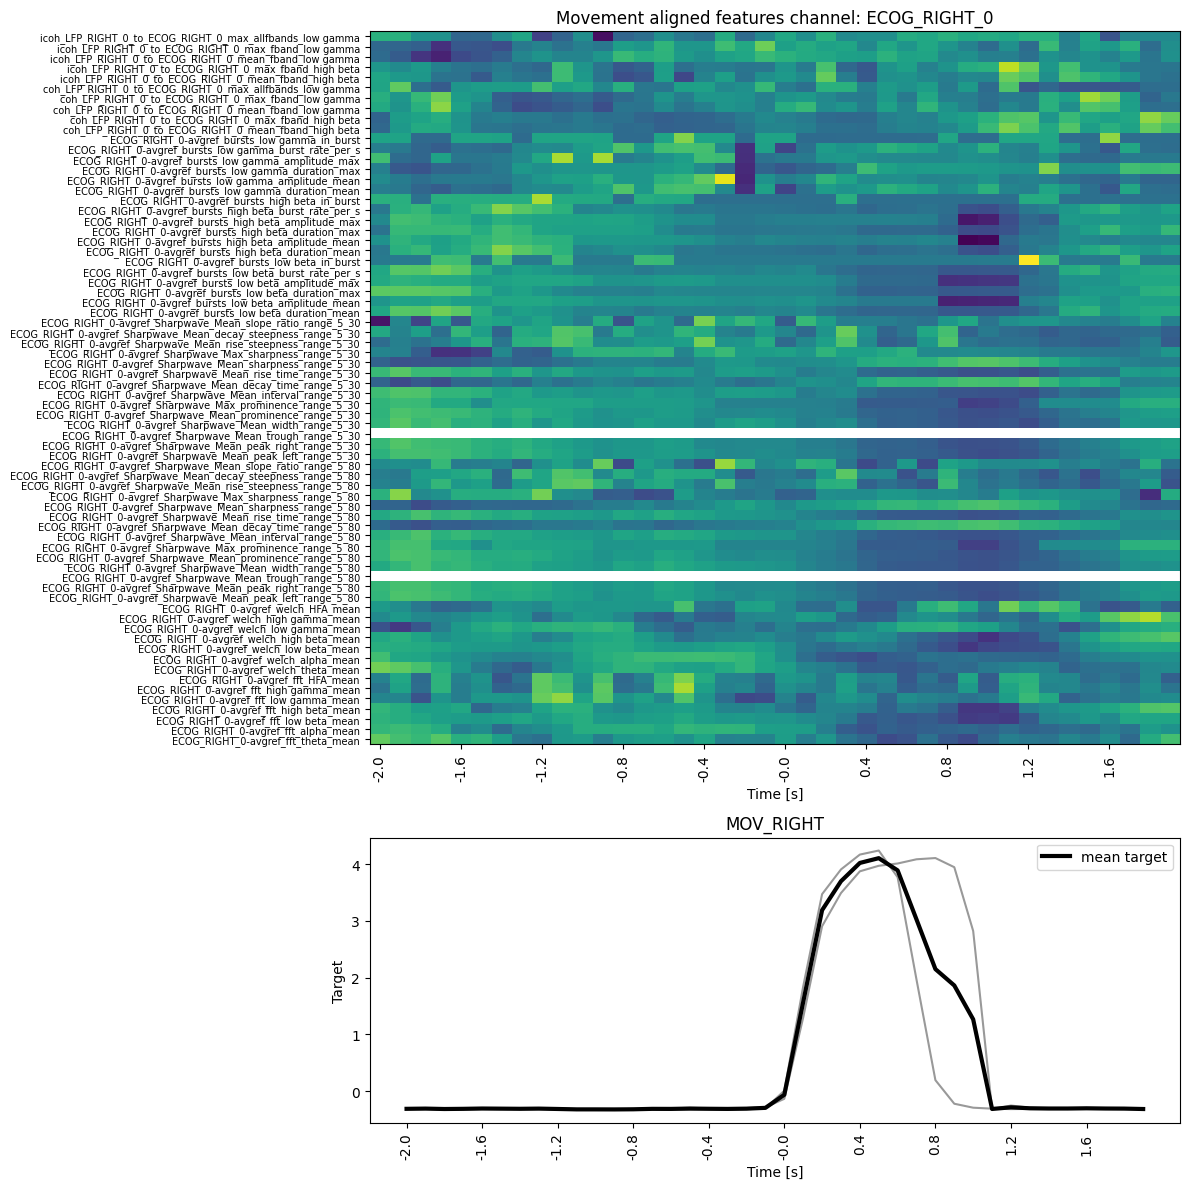

In [11]:
feature_reader.plot_target_averaged_channel(
    ch="ECOG_RIGHT_0",
    list_feature_keywords=None,
    epoch_len=4,
    threshold=0.5,
    ytick_labelsize=7,
    figsize_x=12,
    figsize_y=12,
)